# Recommendation systems

Here, I am going to use the data from [MovieLens](https://movielens.org/) database.
You can download the dataset [here](http://files.grouplens.org/datasets/movielens/).

The 'ml_latest_small' dataset (which I have used here) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

To warm-up, let's start with forming the top movies chart using IMDb weighted rating method.

### IMDb Weighted rating

We want to make the Top movies chart using IMDb weighted rating. Here is the Weighted rating formula:

![alt text](weight-avg.png)

Where:
* v: the number of votes garnered by the movie
* m: the minimum number of votes required for the movie to be in the chart (the prerequisite)
* R: the mean rating of the movie
* C: the mean rating of all the movies in the dataset

The 'ml-latest-small' dataset has a file for movies (with their title and genres) and a separate file for the ratings of users for the movies.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the movies data frame
df_movies = pd.read_csv('ml-latest-small/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# load the ratings data frame
df_ratings = pd.read_csv('ml-latest-small/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
# join two data frames to have genres and title of the movies as well
df = df_movies.merge(df_ratings, how='left', on='movieId').drop(columns=['timestamp'])
df.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5


Let's make a new dataframe which is created for each movie. It is going to have the movieId, movie's title and genres, number of ratings, and the average rating for each movie.

In [5]:
# this will count number of the times that a movie was rated
new_df = df.groupby(['movieId'], as_index=False)['userId'].count().rename(columns={'userId': 'num_rating'})
# this will find the average rating for each movie
new_df['avg_rating'] = df.groupby(['movieId'], as_index=False)['rating'].mean('rating').drop(columns=['movieId'])

# set the average ratings to be ratings in half-point steps
new_df['avg_rating'] = new_df['avg_rating'].mul(2).round().div(2)

# add title and genres of movies to the new dataframe
new_df.insert(1, 'title', df_movies['title'])
new_df.insert(2, 'genres', df_movies['genres'])

new_df.head()

,movieId,title,genres,num_rating,avg_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,215,4.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,110,3.5
2,3,Grumpier Old Men (1995),Comedy|Romance,52,3.5
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,7,2.5
4,5,Father of the Bride Part II (1995),Comedy,49,3.0


Let's start cleaning our dataframe! First, I will check for null values in our dataframe. Then, I will add a seperate column which shows the released year for each movie. I will clean the name of the movies as well, so the movie title is "The American President" instead of "American President, The". Lastly, I will add genres of each movie to a list, so the genres are lists instead of '|'-seperated strings. This way dealing with genres would be easier.

In [6]:
new_df.isnull().sum()

movieId        0
title          0
genres         0
num_rating     0
avg_rating    18
dtype: int64

We can see that there is no rating for 18 movies! But for our analysis, this is not critical and we do not need to worry about these null values now.

In [7]:
# move released year of each movie from inside paranthesis in title to a new column
new_df.insert(2, 'year', new_df['title'].apply(lambda title: title[-5:-1]))
new_df['title'] = new_df['title'].apply(lambda title: title[:-7])

new_df.head(15)

,movieId,title,year,genres,num_rating,avg_rating
0,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,215,4.0
1,2,Jumanji,1995,Adventure|Children|Fantasy,110,3.5
2,3,Grumpier Old Men,1995,Comedy|Romance,52,3.5
3,4,Waiting to Exhale,1995,Comedy|Drama|Romance,7,2.5
4,5,Father of the Bride Part II,1995,Comedy,49,3.0
5,6,Heat,1995,Action|Crime|Thriller,102,4.0
6,7,Sabrina,1995,Comedy|Romance,54,3.0
7,8,Tom and Huck,1995,Adventure|Children,8,3.0
8,9,Sudden Death,1995,Action,16,3.0
9,10,GoldenEye,1995,Action|Adventure|Thriller,132,3.5


In [8]:
# modify the title
new_df['title'] = new_df['title'].apply(lambda title: title.split(',')[1] + ' ' + title.split(',')[0] if ',' in title else title)

In [9]:
# convert genres string to a list
new_df['genres'] = new_df['genres'].apply(lambda genres: genres.split('|'))

new_df.head(15)

,movieId,title,year,genres,num_rating,avg_rating
0,1,Toy Story,1995,"[Adventure, Animation, Children, Comedy, Fantasy]",215,4.0
1,2,Jumanji,1995,"[Adventure, Children, Fantasy]",110,3.5
2,3,Grumpier Old Men,1995,"[Comedy, Romance]",52,3.5
3,4,Waiting to Exhale,1995,"[Comedy, Drama, Romance]",7,2.5
4,5,Father of the Bride Part II,1995,[Comedy],49,3.0
5,6,Heat,1995,"[Action, Crime, Thriller]",102,4.0
6,7,Sabrina,1995,"[Comedy, Romance]",54,3.0
7,8,Tom and Huck,1995,"[Adventure, Children]",8,3.0
8,9,Sudden Death,1995,[Action],16,3.0
9,10,GoldenEye,1995,"[Action, Adventure, Thriller]",132,3.5


Our dataframe is clean now. We can continue to the next step!

In [10]:
average_rating = new_df['avg_rating'].mean()   # C in the weighted rating formula
average_rating

3.2641402714932126

For this recommender, I am going to use the number of votes garnered by the 95th percentile movie as my value for m. In other words, for a movie to be considered in the rankings, it must have garnered more votes than at least 95% of the movies present in your dataset. Additionally, the number of votes garnered by the 95th percentile movie is used in the weighted formula described previously to come up with the value for the scores.

In [11]:
m = new_df['num_rating'].quantile(0.95)
m

47.0

In [12]:
chart_movies = new_df[new_df['num_rating'] >= m]
chart_movies.shape

(491, 6)

We can see that from 9742 movies, only 491 movies (~ 5%) made the cut!

In [14]:
# calculating the weighted rating for movies
def weighted_rating(movie, m=m, C=average_rating):
    v = movie['num_rating']
    R = movie['avg_rating']

    return ((v / (v + m)) * R) + ((m / (v + m)) * C)

# apply the function to all rows to get scores for the movies
chart_movies.loc[:, 'w_rating'] = chart_movies.apply(weighted_rating, axis=1)

In [15]:
chart_movies = chart_movies.sort_values('w_rating', ascending=False)
chart_movies.head(20)

,movieId,title,year,genres,num_rating,avg_rating,w_rating
277,318,The Shawshank Redemption,1994,"[Crime, Drama]",317,4.5,4.340425
2226,2959,Fight Club,1999,"[Action, Crime, Drama, Thriller]",218,4.5,4.280810
659,858,The Godfather,1972,"[Crime, Drama]",192,4.5,4.256965
922,1221,The Godfather: Part II,1974,"[Crime, Drama]",129,4.5,4.169969
6315,48516,The Departed,2006,"[Crime, Drama, Thriller]",107,4.5,4.122822
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,1964,"[Comedy, War]",97,4.5,4.096629
686,904,Rear Window,1954,"[Mystery, Thriller]",84,4.5,4.056600
975,1276,Cool Hand Luke,1967,[Drama],57,4.5,3.941486
314,356,Forrest Gump,1994,"[Comedy, Drama, Romance, War]",329,4.0,3.908018
257,296,Pulp Fiction,1994,"[Comedy, Crime, Drama, Thriller]",307,4.0,3.902301


Text(0, 0.5, 'Movie Title')

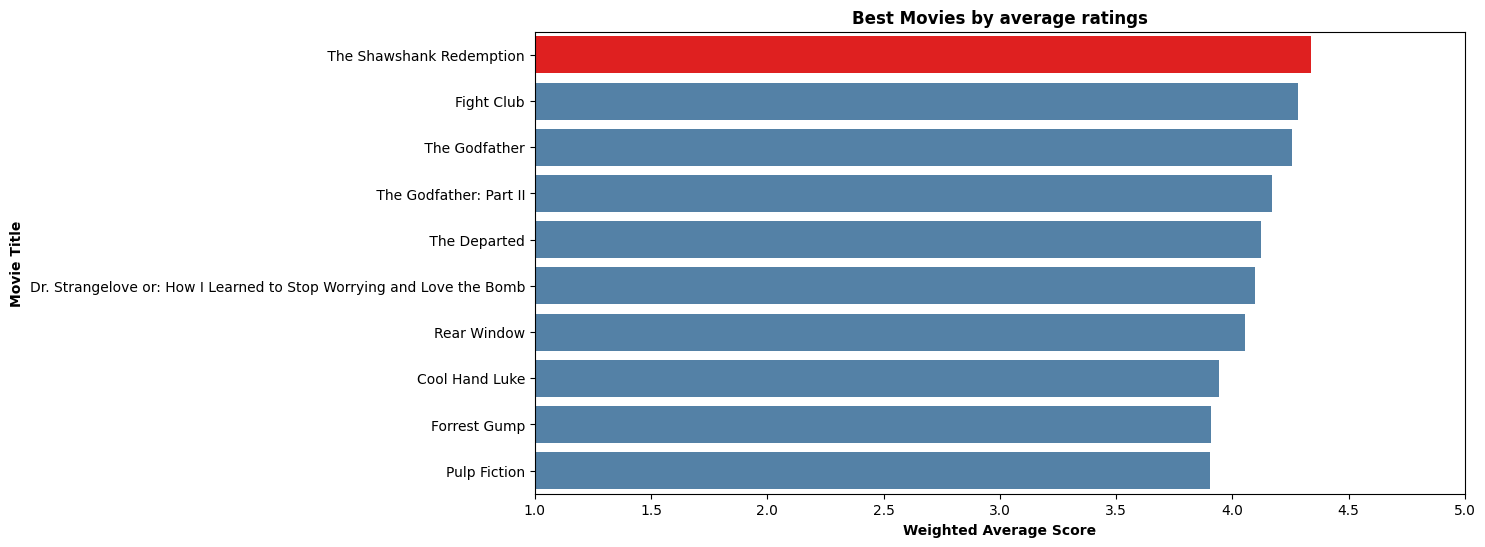

In [16]:
plt.figure(figsize=(12,6))
color = ['steelblue' if x < max(chart_movies['w_rating'].head(10)) else 'red' for x in chart_movies['w_rating'].head(10)]
sns.barplot(chart_movies, x=chart_movies['w_rating'].head(10), y=chart_movies['title'].head(10), hue=chart_movies['title'].head(10), legend=False, palette=color)

plt.xlim(1, 5)
plt.title('Best Movies by average ratings', weight='bold')
plt.xlabel('Weighted Average Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')


We can see that **The Shawshank Redemption** has the highest score among other movies and probably will be recommended more often!

## Colaborative filtering (CF)

In the context of recommendation systems, collaborative filtering is a method of making predictions about the interests of a user by analyzing the taste of users which are similar to the said user. The idea of filtering patterns by collaborating multiple viewpoints is why it is called collaborative filtering. [Here](https://en.wikipedia.org/wiki/Collaborative_filtering), you can find valuable information about CF.

First, let's do some exploratory analysis on our dataset.

In [17]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [18]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [19]:
df_ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Text(0.5, 1.0, 'Distribution of movie ratings')

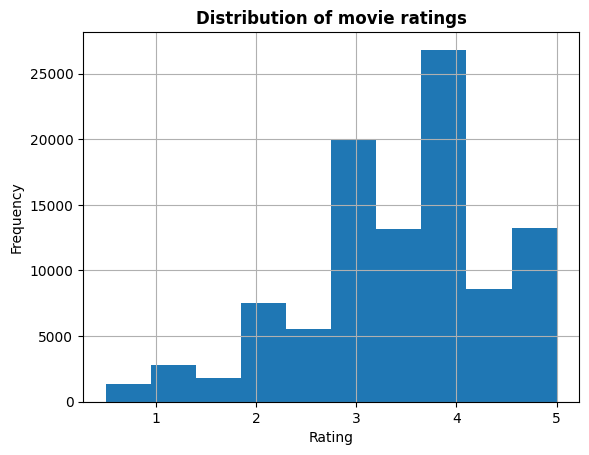

In [20]:
df_ratings['rating'].hist(grid=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of movie ratings', fontweight='bold')

#### Model-based Collaborative Filtering:

In [21]:
# install these two useful packages
! pip install scikit-surprise
! pip install fastai

In [22]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader
from surprise import NMF, SVD, KNNBasic
from surprise.model_selection import cross_validate, GridSearchCV

In [23]:
df_ratings = df_ratings[['userId', 'movieId', 'rating']]
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [24]:
# check to see if there is any NaN value in the rating column
df_ratings['rating'].isnull().sum()

0

In [25]:
df_ratings.sort_values('rating', ascending=False)

,userId,movieId,rating
34031,232,3147,5.0
50717,328,1080,5.0
18166,115,487,5.0
18165,115,480,5.0
76157,479,3308,5.0
...,...,...,...
99278,608,4679,0.5
99277,608,4678,0.5
95668,600,4744,0.5
99269,608,4621,0.5


In [26]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_ratings, reader)

In [27]:
# different algorithms to make recommendation (Matrix factorization methods, KNN)
## SVD
algo = SVD()
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Access the results
print(results)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8802  0.8676  0.8786  0.8814  0.8653  0.8746  0.0068  
MAE (testset)     0.6760  0.6672  0.6737  0.6783  0.6645  0.6719  0.0053  
Fit time          0.33    0.34    0.34    0.33    0.34    0.34    0.00    
Test time         0.03    0.07    0.03    0.07    0.03    0.05    0.02    
{'test_rmse': array([0.88024836, 0.86760708, 0.87860679, 0.88137615, 0.86533425]), 'test_mae': array([0.67601864, 0.66717968, 0.67365427, 0.67834727, 0.6645163 ]), 'fit_time': (0.3318030834197998, 0.33652782440185547, 0.34052181243896484, 0.33002328872680664, 0.33748507499694824), 'test_time': (0.03162193298339844, 0.07094407081604004, 0.03113579750061035, 0.069091796875, 0.03075885772705078)}


In [28]:
## NMF
algo = NMF()
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Access the results
print(results)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9232  0.9189  0.9183  0.9289  0.9200  0.9219  0.0039  
MAE (testset)     0.7059  0.7038  0.7039  0.7123  0.7049  0.7061  0.0032  
Fit time          0.61    0.61    0.61    0.59    0.54    0.59    0.03    
Test time         0.07    0.03    0.03    0.03    0.03    0.04    0.02    
{'test_rmse': array([0.92321491, 0.91893948, 0.91833321, 0.92894977, 0.92003002]), 'test_mae': array([0.70588786, 0.70375282, 0.70394159, 0.71227171, 0.70487566]), 'fit_time': (0.6093089580535889, 0.6092181205749512, 0.6107358932495117, 0.5859677791595459, 0.5439581871032715), 'test_time': (0.07160115242004395, 0.025959014892578125, 0.026964902877807617, 0.02838420867919922, 0.02515888214111328)}


In [29]:
## KNN

algo = KNNBasic()
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Access the results
print(results)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9533  0.9516  0.9550  0.9461  0.9432  0.9498  0.0045  
MAE (testset)     0.7298  0.7297  0.7299  0.7253  0.7244  0.7278  0.0024  
Fit time          0.02    0.03    0.03    0.03    0.03    0.03    0.00    
Test time         0.33    0.36    0.32    0.37    0.37    0.35    0.02    
{'test_rmse': array([0.95333076, 0.95158477, 0.95503994, 0.94608506, 0.9431506 ]), 'test_mae': array([0.72980638, 0.72969572, 0.72992845, 0.72532621, 0.72441831]), 'fit_time': (0.023940086364746094, 0.

We can see that SVD has the best results.